In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import detrend
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from statsmodels.nonparametric.smoothers_lowess import lowess


sys.path.append('/scistor/ivm/jsn295/Weave')
from Weave.models import fit_predict, fit_predict_evaluate, evaluate, hyperparam_evaluation, map_foldindex_to_groupedorder, BaseExceedenceModel, HybridExceedenceModel
from Weave.utils import brier_score_clim, reliability_plot

In [2]:
basepath_base = '/scistor/ivm/jsn295/bootstrap_base/BaseExceedenceModel.bs.parquet'
basepath_hybrid = '/scistor/ivm/jsn295/bootstrap_hybrid_base/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet'
basepath_hybrid_strict = '/scistor/ivm/jsn295/bootstrap_hybrid_base_noncv/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet'
basepath_normcor = '/scistor/ivm/jsn295/non_hybrid/bootstrap_normco/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet'
basepath_bs = '/scistor/ivm/jsn295/bootstrap_hybrid/max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Relative to fixed climatology
basepath_hybrid_full = '/scistor/ivm/jsn295/bootstrap_hybrid_noncv_base_noncv/fit_base_to_all_cv=True.max_depth=5.n_estimators=2500.min_samples_split=30.max_features=35.n_jobs=19.bs.parquet' # Logistic regression fitted to the full (non-cv) dataset.

In [3]:
df = pd.read_parquet(basepath_hybrid_full) #pd.read_parquet(basepath_hybrid_strict)

In [5]:
df.columns

Index(['0.05', '0.5', '0.95', 'clim'], dtype='object', name='bss_quantile')

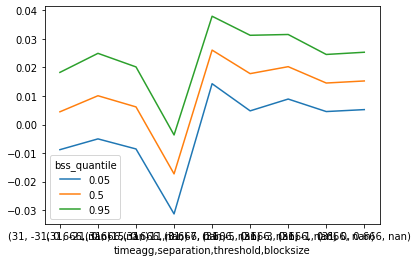

In [46]:
df.loc[(31,slice(None),0.666,np.nan),:].plot()

This one is pretty interesting. So there seems to be a window of certain leadtimes in which this is better predictable. (bootstrap bounds are too small however, 31 timeagg needs blocks of at least 30).

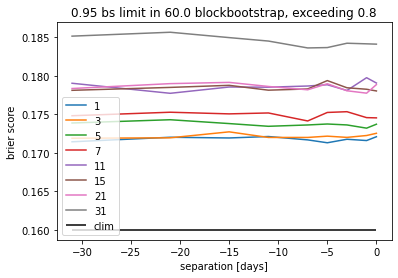

In [5]:
# Plotting the upper bound for this threshold with different timeaggs against separation
threshold = 0.8
blocksize = 60.0
fig,ax = plt.subplots()
for timeagg in df.index.get_level_values('timeagg').unique().sort_values():
    select = df.loc[(timeagg,slice(None),threshold,blocksize),['0.95','clim']]
    ax.plot(select.index.get_level_values('separation'),select['0.95'], label = str(timeagg))
ax.hlines(select.iloc[0,-1], xmin = df.index.get_level_values('separation').min(), xmax = df.index.get_level_values('separation').max(),label = 'clim')
ax.set_xlabel('separation [days]')
ax.set_ylabel('brier score')
ax.set_title(f'0.95 bs limit in {blocksize} blockbootstrap, exceeding {threshold}')
ax.legend()

This is very interesting. Apparently anything of a duration lower that 7 days are very hard to forecast from -20 to -7 days. You also see that the blue curve drops of earlier (the event to be forecasted is less into the future). Interestingly the slope of 15, 21 and 31 days is just gradual. 11 is hardly heeling.
You see exactly the same pattern for the different bootstrap levels (and/or median). Not so sure if also the same pattern for the different thresholds

You see more curvature for the lower thresholds. Also extremes pretty much unpredictable. But perhaps this is just the brier score scaling. Transform to skillscore for those that do not have it

In [4]:
for quantile in ['0.05','0.5','0.95']:
    if 'clim' in df.columns:
        df[f'{quantile}_skill'] = 1 - df[quantile] / df['clim']
    else:
        df[f'{quantile}_skill'] = df[float(quantile)] # Originally a float index because no 'clim' string was appended

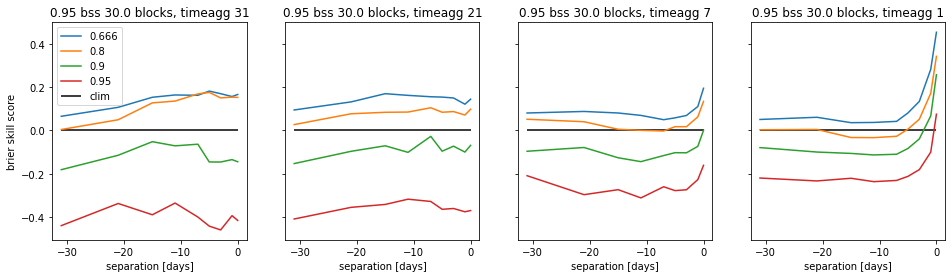

In [102]:
blocksize = 30.0
timeaggs = [1,7,21,31][::-1]
fig,axes = plt.subplots(ncols = len(timeaggs), squeeze = False, sharey=True, figsize = (4*len(timeaggs),4))
for i, timeagg in enumerate(timeaggs):
    ax = axes[0,i]
    for threshold in df.index.get_level_values('threshold').unique().sort_values():
        selection = df.loc[(timeagg,slice(None),threshold,blocksize),['0.95_skill']]
        ax.plot(selection.index.get_level_values('separation'),selection, label = str(threshold))
    ax.hlines(0, xmin = df.index.get_level_values('separation').min(), xmax = df.index.get_level_values('separation').max(),label = 'clim')
    ax.set_xlabel('separation [days]')
    if i == 0:
        ax.set_ylabel('brier skill score')
        ax.legend()
    ax.set_title(f'0.95 bss {blocksize} blocks, timeagg {timeagg}')


Thresholds show similar curvature (except for timeagg = 31).
Why would the predictive skill remain flat with decreasing separation for the larger time aggregations, and the more extreme thresholds. (Not being able to use persistence of the synoptic?)
Quality of information should be the same per separation. So quality differences for the separations might explain curves (though then these shapes should be present regardless of the resptimeagg and the exceedence threshold).
Conceptually it might be something like 'missing' the opportunity of the teleconnection or feedback mechanism, because the causility path takes too long (affects too late after the current combination of gap-size plus response timeagg)

One can note that the widest uncertainty range is usually for the largest timescales. Not necessarily in terms of the purple area, but actually the widening by the block-bootstrapping. I am curious to compare different thresholds. So let's visualize this in terms of the skillscore (to remain comparable)

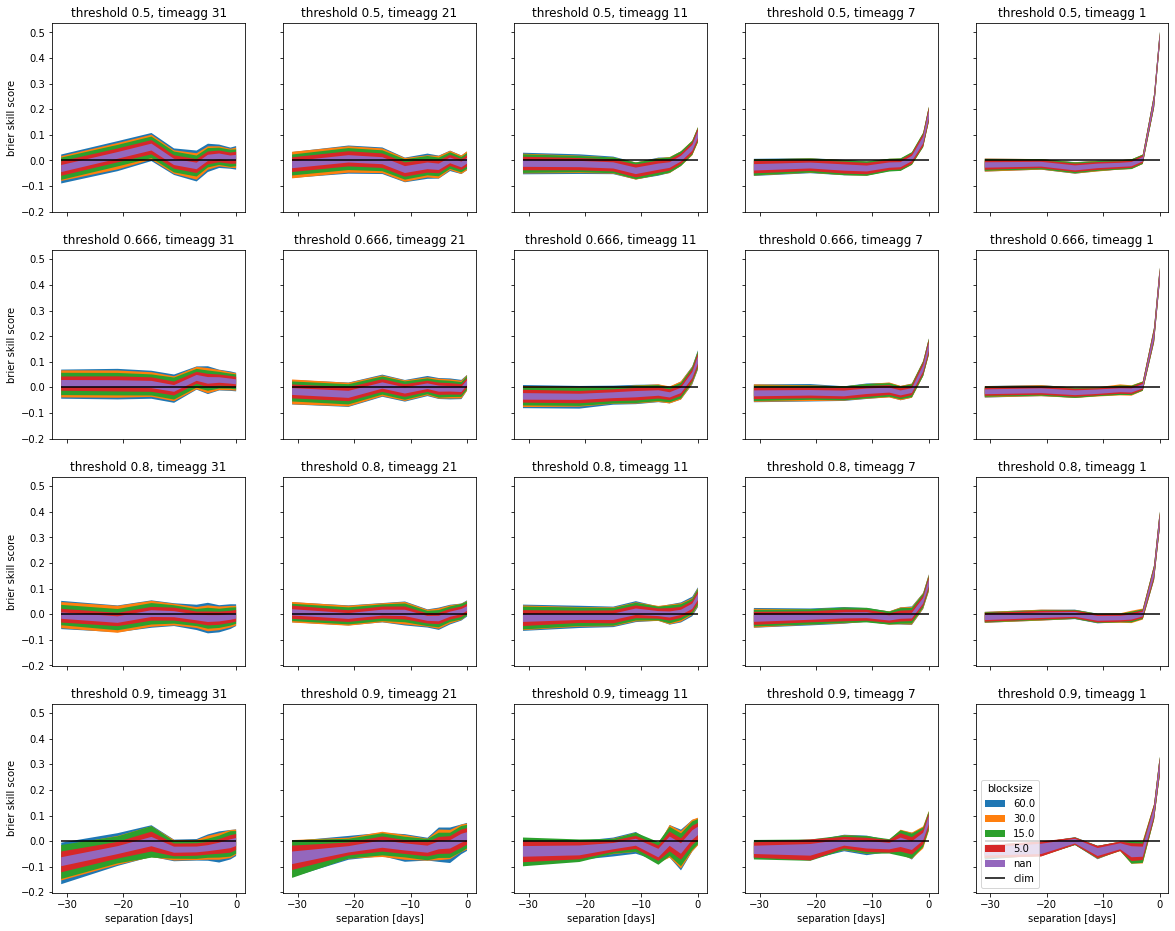

In [5]:
# Demonstration of the effect of different block bootstrap sizes. in terms of skill score
thresholds = df.index.get_level_values('threshold').unique().sort_values()
timeaggs = [1,7,11,21,31][::-1]
fig,axes = plt.subplots(ncols = len(timeaggs), nrows = len(thresholds), squeeze = False, sharey=True, sharex = True, figsize = (4*len(timeaggs),4*len(thresholds)))
fig.patch.set_facecolor('white')
for i, threshold in enumerate(thresholds):
    for j, timeagg in enumerate(timeaggs):
        ax = axes[i,j]
        for blocksize in df.index.get_level_values('blocksize').unique()[::-1]:
            selection = df.loc[(timeagg,slice(None),threshold,blocksize),['0.05_skill','0.95_skill']]
            ax.fill_between(x = selection.index.get_level_values('separation'), y1 = selection['0.05_skill'], y2 = selection['0.95_skill'],label = str(blocksize))
        
        ax.hlines(y = 0, xmin = df.index.get_level_values('separation').min(), xmax = df.index.get_level_values('separation').max(),label = 'clim')
        ax.set_title(f'threshold {threshold}, timeagg {timeagg}')
        if j == 0:
            ax.set_ylabel('brier skill score')
        if i == len(thresholds) - 1:
            ax.set_xlabel('separation [days]')
            
axes[-1,-1].legend(title = 'blocksize', loc = 'lower left')

Looking at this, you just see that extremes are harder to predict. But there is a hint of windows. For instance the threshold 0.9 at long timeaggs and a not so strict bootstrapping has shown skill.

In terms of skillfull opportunities, also the 'dip' in skill of forecasting 7day exceedance of 0.8 is very interesting.

### Comparing for instance the 31 day skill with reliability diagrams

In [2]:
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.detrended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
separations = [-31,-21,-15]
y = pd.read_parquet(Y_path).loc[:,(slice(None),31,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separations,slice(None),'spatcov')].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)
y = y > y.quantile(0.666)

In [58]:
results = []
for separation in separations:
    X_select = X.loc[:,(slice(None),slice(None),slice(None),slice(None),separation)]
    m = RandomForestClassifier(max_depth = 7, min_samples_split = 40, n_jobs = 20, max_features = 35, n_estimators = 1500)
    preds = fit_predict(m, X_select, y, n_folds = 5, split_on_year = True)
    #preds.index = preds.index.droplevel('fold')
    preds = preds.to_frame()
    preds.columns = pd.Index([separation], name = 'separation')
    results.append(preds)

In [59]:
allfolds = pd.concat(results, axis = 1)
no4 = allfolds.loc[([0,1,2,3],),:]
allfolds.index = allfolds.index.droplevel('fold')
no4.index = no4.index.droplevel('fold')

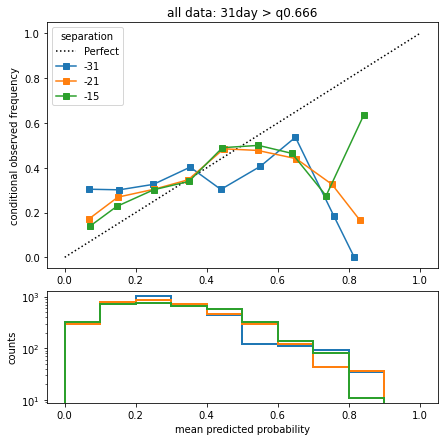

In [60]:
fig, axes = reliability_plot(y_true=y, y_probs = allfolds)
axes[0].set_title('all data: 31day > q0.666')
plt.show()

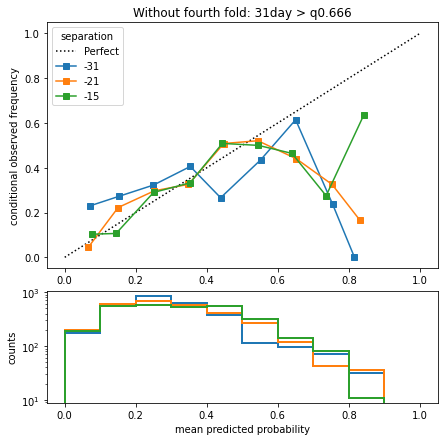

In [61]:
fig, axes = reliability_plot(y_true=y.loc[no4.index], y_probs = no4)
axes[0].set_title('Without fourth fold: 31day > q0.666')
plt.show()

Here we see truly that the fourth fold degrades by underforecasting the actual event. Small predicted probability is accompanied by higher conditional frequency.

### Now test whether the 31 skill at a certain separation is less present than smaller timeaggs at the same separation.

In [8]:
respaggs = [31,21,15,7]
y = pd.read_parquet(Y_path).loc[:,(slice(None),respaggs,slice(None))] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),-21,slice(None),'spatcov')].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)
y = y > y.quantile(0.666)

In [9]:
results = []
for respagg in respaggs:
    y_select = y.loc[:,(slice(None),respagg,slice(None))].iloc[:,0]
    m = RandomForestClassifier(max_depth = 7, min_samples_split = 40, n_jobs = 20, max_features = 35, n_estimators = 1500)
    preds = fit_predict(m, X, y_select, n_folds = 5, split_on_year = True)
    #preds.index = preds.index.droplevel('fold')
    preds = preds.to_frame()
    preds.columns = pd.Index([respagg], name = 'response_agg')
    results.append(preds)

In [10]:
allfolds = pd.concat(results, axis = 1)
no4 = allfolds.loc[([0,1,2,3],),:]
allfolds.index = allfolds.index.droplevel('fold')
no4.index = no4.index.droplevel('fold')

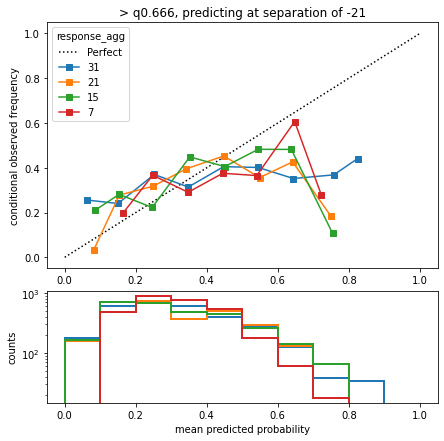

In [12]:
fig, axes = reliability_plot(y_true=y.loc[no4.index,:], y_probs = no4)
axes[0].set_title(f'> q0.666, predicting at separation of -21')
plt.show()

### And test whether the skill is more than at 0.5

In [13]:
y = pd.read_parquet(Y_path).loc[:,(slice(None),31,slice(None))] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),-15,slice(None),'spatcov')].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)

In [14]:
quantiles = [0.5,0.666,0.8,0.9]
results = []
ys = []
for quantile in quantiles:
    y_select = y.iloc[:,0] > quantile
    ys.append(y_select)
    m = RandomForestClassifier(max_depth = 7, min_samples_split = 40, n_jobs = 20, max_features = 35, n_estimators = 1500)
    preds = fit_predict(m, X, y_select, n_folds = 5, split_on_year = True)
    preds = preds.to_frame()
    preds.columns = pd.Index([quantile], name = 'quantile')
    results.append(preds)

In [16]:
ys = pd.concat(ys, keys = quantiles, axis = 1)
allfolds = pd.concat(results, axis = 1)
no4 = allfolds.loc[([0,1,2,3],),:]
allfolds.index = allfolds.index.droplevel('fold')
no4.index = no4.index.droplevel('fold')

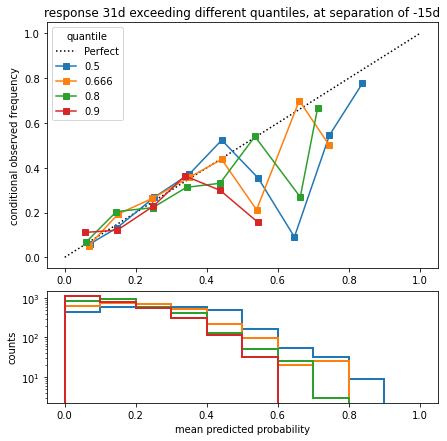

In [21]:
fig, axes = reliability_plot(y_true=ys.loc[no4.index,:], y_probs = no4)
axes[0].set_title(f'response 31d exceeding different quantiles, at separation of -15d')
plt.show()

# Testing the effect of different detrending

In [30]:
respagg = 1
separation = -21
threshold = 0.666
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.detrended.parquet'
Y_tr_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0] # Only summer
y_tr = pd.read_parquet(Y_tr_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0]
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separation,slice(None),'spatcov')].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)
y_tr = y_tr.reindex(X.index)
#X = X.iloc[:,np.random.choice(a = np.arange(X.shape[1]), size = 500, replace = False)]

In [ ]:
y_tr.plot()

In [ ]:
y.plot()

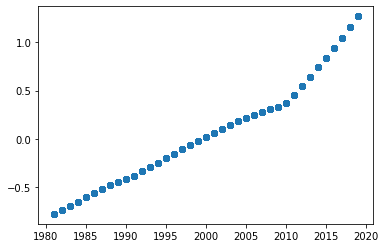

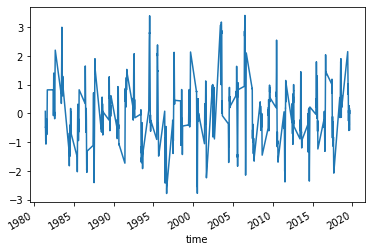

In [3]:
test = lowess(y_tr,y_tr.index.year, it = 1, frac = 0.5)
plt.scatter(x = test[:,0], y = test[:,1])
plt.show()
y_new = y_tr - test[:,1]
y_new.plot()

In [24]:
y_new = y_new > y_new.quantile(threshold)
y_tr = y_tr > y_tr.quantile(threshold)
y = y > y.quantile(threshold)

In [25]:
evaluate_kwds = dict(scores = [brier_score_loss], score_names = ['bs'])
m = RandomForestClassifier(n_estimators=1500, n_jobs=15, min_samples_split=40, max_depth=7, max_features = 35)

In [10]:
preds = fit_predict(model = m, X_in = X, y_in = y_new, n_folds = 5)
preds.index = preds.index.droplevel('fold')
ret = evaluate(y_true = y_new, y_pred=preds, **evaluate_kwds)

In [11]:
ret

score
bs    0.225524
dtype: float64

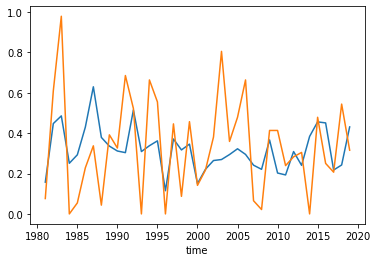

In [12]:
preds.groupby(preds.index.year).mean().plot()
y_new.groupby(y_new.index.year).mean().plot()

In [13]:
preds2 = fit_predict(model = m, X_in = X, y_in = y, n_folds = 5)
preds2.index = preds2.index.droplevel('fold')
ret2 = evaluate(y_true = y, y_pred=preds2, **evaluate_kwds)

In [14]:
ret2

score
bs    0.221804
dtype: float64

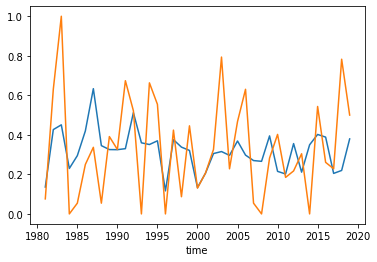

In [15]:
preds2.groupby(preds2.index.year).mean().plot()
y.groupby(y.index.year).mean().plot()

In [16]:
preds3 = fit_predict(model = m, X_in = X, y_in = y_tr, n_folds = 5)
preds3.index = preds3.index.droplevel('fold')
ret3 = evaluate(y_true = y_tr, y_pred=preds3, **evaluate_kwds)

In [17]:
ret3

score
bs    0.203719
dtype: float64

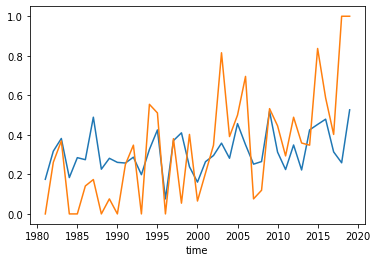

In [18]:
preds3.groupby(preds3.index.year).mean().plot()
y_tr.groupby(y_tr.index.year).mean().plot()

In [19]:
brier_score_clim(threshold)

0.22244399999999998

In [20]:
m2 = RandomForestClassifier(n_estimators=1500, n_jobs=20, min_samples_split=20, max_depth=15, max_features = 35)
preds4 = fit_predict(model = m2, X_in = X, y_in = y, n_folds = 5)
preds4.index = preds4.index.droplevel('fold')
ret4 = evaluate(y_true = y, y_pred=preds4, **evaluate_kwds)

In [21]:
ret4

score
bs    0.219331
dtype: float64

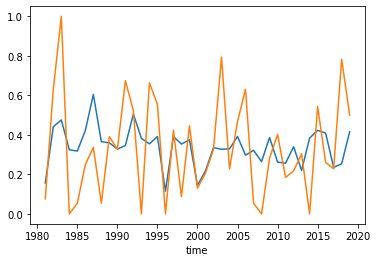

In [22]:
preds4.groupby(preds4.index.year).mean().plot()
y.groupby(y.index.year).mean().plot()

## Hybrid models
Dealing with the idea that perhaps relations are non-stationary (not all residuals are equal). So we need a 'climate change aware' forest, but also one that is not learning the trend (waste of learning resources). 
So something like gmst or co2 or years as an input.
Predicting trended data in the hybrid setting means that also a different baseline is needed.

In [7]:
timeframe = pd.DataFrame(scale(np.repeat(X.index.to_julian_date().values[:,np.newaxis], 5, axis = 1), axis = 0, with_mean = True, with_std = False), index = X.index, columns = pd.MultiIndex.from_product([list(range(5)),['year']] + [[None]] * 5, names = X.columns.names))
X_new = pd.concat([X,timeframe], axis = 1)

In [26]:
m2 = RandomForestClassifier(n_estimators=1500, n_jobs=20, min_samples_split=20, max_depth=15, max_features = 35)
preds5 = fit_predict(model = m2, X_in = X_new, y_in = y, n_folds = 5)
preds5.index = preds5.index.droplevel('fold')
ret5 = evaluate(y_true = y, y_pred=preds5, **evaluate_kwds)

In [27]:
ret5

score
bs    0.218915
dtype: float64

Conclusion from the above: 'time-aware' fitting does not really help.
We need to remove trend more intelligently. We fit a base model.

In [65]:
# Non-cv reference forecast of base model
lr4 = BaseExceedenceModel()
preds7 = fit_predict(model = lr4, X_in = X, y_in = y_tr, X_val = X, y_val = y_tr)
ret7 = evaluate(y_true = y_tr, y_pred=preds7, **evaluate_kwds)

In [66]:
ret7

score
bs    0.189779
dtype: float64

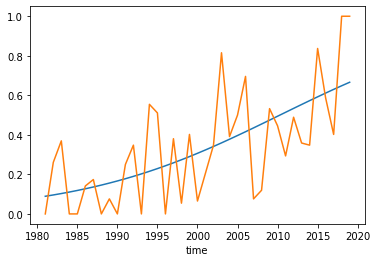

In [67]:
preds7.groupby(preds7.index.year).mean().plot()
y_tr.groupby(y_tr.index.year).mean().plot()

In [68]:
lr3 = BaseExceedenceModel()
preds6 = fit_predict(model = lr3, X_in = X, y_in = y_tr, n_folds = 5)
preds6.index = preds6.index.droplevel('fold')
ret6 = evaluate(y_true = y_tr, y_pred=preds6, **evaluate_kwds)

In [69]:
ret6

score
bs    0.193742
dtype: float64

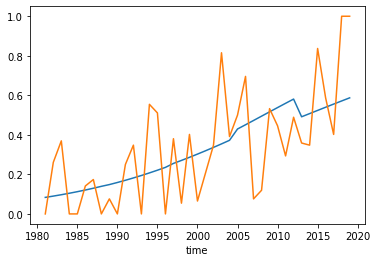

In [70]:
preds6.groupby(preds6.index.year).mean().plot()
y_tr.groupby(y_tr.index.year).mean().plot()

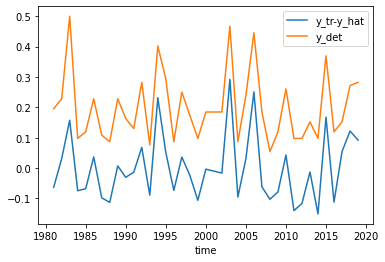

In [46]:
(y_tr - preds6).groupby(preds6.index.year).mean().plot(label = 'y_tr-y_hat')
y.groupby(y.index.year).mean().plot(label = 'y_det')
plt.legend()

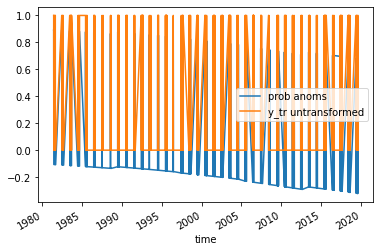

In [47]:
(y_tr - preds6).plot(label = 'prob anoms')
(y + 0.0).plot(label = 'y_tr untransformed')
plt.legend()

Text(0.5, 1.0, 'What the RF will train on')

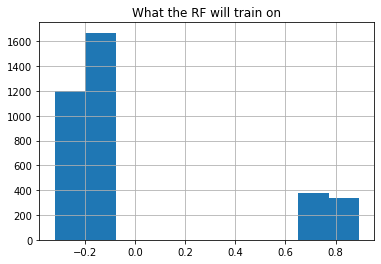

In [48]:
(y_tr - preds6).hist()
plt.title('What the RF will train on')

In [81]:
m4 = HybridExceedenceModel(n_estimators=1500, n_jobs=20, min_samples_split=40, max_depth=7, max_features = 35)
preds10 = fit_predict(model = m4, X_in = X, y_in = y_tr, n_folds = 5)
preds10.index = preds10.index.droplevel('fold')
ret10 = evaluate(y_true = y_tr, y_pred=preds10, **evaluate_kwds)

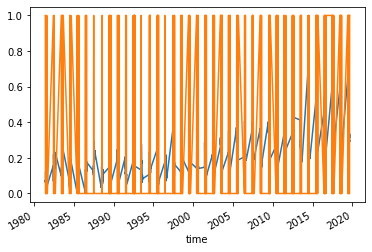

In [50]:
preds10.plot()
(y_tr + 0.0).plot()

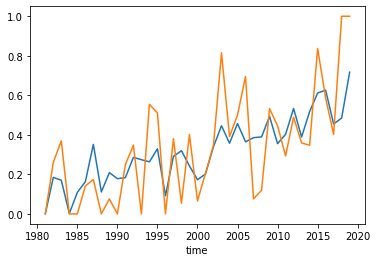

In [72]:
preds10.groupby(preds10.index.year).mean().plot()
y_tr.groupby(y_tr.index.year).mean().plot()

In [82]:
ret10

score
bs    0.193303
dtype: float64

In [74]:
m4

Hybrid combination with RandomForestRegressor(max_depth=7, max_features=35, min_samples_split=40,
                      n_estimators=1500, n_jobs=20) on top of LogisticRegression with scaled time index as only input: penalty=l2, C=1.0, fit_intercept=True

## Non-stationarity in input?

In [ ]:
X.loc[:,(3,'siconc_nhmin')].groupby(X.index.year).mean().plot(legend = False)

In [ ]:
X.loc[:,(3,'siconc_nhmin',slice(None),slice(None),slice(None),slice(None),'spatcov')].groupby(X.index.year).mean().plot(legend = False)

## Hyperparams of the trended basemodel?

In [28]:
hyperparams = dict(C = [1000.0, 10.0,5.0,1.0,0.7,0.5,0.3,0.001])
otherparams = dict(fit_intercept = True, penalty = 'l2')
ret = hyperparam_evaluation(model = BaseExceedenceModel, X_in = X, y_in = y_tr, hyperparams= hyperparams, other_kwds=otherparams, fit_predict_evaluate_kwds= dict(n_folds = 5, evaluate_kwds = evaluate_kwds))

In [ ]:
ret.groupby('score').mean()

The penalization here has hardly an influence. Only one predictor. Fit intercept is absolutely neccesary

## Resolution as a function of model depth
From hyperparam optimization it seems that the hybrid model has a preference (in terms of bs) for being less deep. How does that show in reliability/resolution. And how does that compare to the resolution already present in the trended baseline model.

In [6]:
respagg = 31
separation = -21
threshold = 0.666
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)
y = y > threshold

In [7]:
models = dict(
    base = BaseExceedenceModel(),
    hybrid_3 = HybridExceedenceModel(max_depth = 3, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 1500),
    hybrid_5 = HybridExceedenceModel(max_depth = 5, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 1500),
    hybrid_7 = HybridExceedenceModel(max_depth = 7, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 1500))

preds = dict()
for key, model in models.items():
    preds.update({key:fit_predict(model, X, y, n_folds = 5, split_on_year = True)})
preds = pd.DataFrame(preds)
preds.columns.set_names(['type'], inplace = True)
preds.index = preds.index.droplevel('fold')

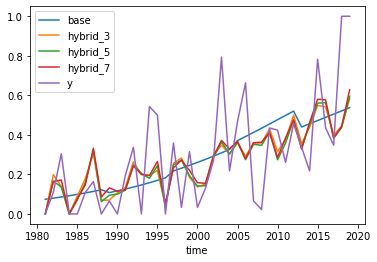

In [8]:
preds.groupby(preds.index.year).mean().plot()
y.groupby(y.index.year).mean().plot(label = 'y')
plt.legend()
plt.show()

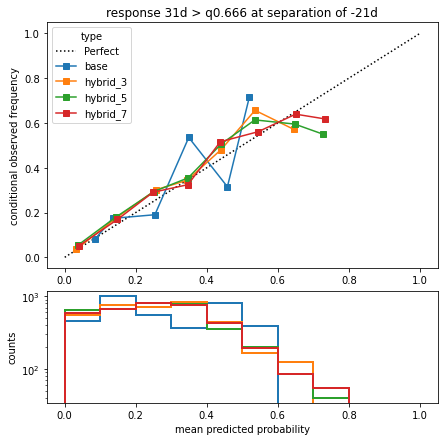

In [9]:
fig, axes = reliability_plot(y_true=y, y_probs = preds)
axes[0].set_title(f'response {respagg}d > q{threshold} at separation of {separation}d')
plt.show()

### Reliability as a function of timeagg
For one separation prove that predictability is not because of predictability of the first few days (Although the climate signal is less for the smaller timeaggs, variability is more challenging to handle). Lesson from previously.
For the chosen model of depth 5.

In [125]:
respaggs = [31,21,15,7]
separation = -15
threshold = 0.666
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'

predsbase = dict()
preds = dict()
ys = dict()

for respagg in respaggs:
    y = pd.read_parquet(Y_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0] # Only summer
    X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any')
    map_foldindex_to_groupedorder(X, n_folds = 5)
    y = y.reindex(X.index)
    y = y > threshold
    base = BaseExceedenceModel()
    model = HybridExceedenceModel(max_depth = 5, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 1500)
    predsbase.update({respagg:fit_predict(base, X_in = X, y_in = y, X_val = X, y_val = y)})
    preds.update({respagg:fit_predict(model, X, y, n_folds = 5, split_on_year = True)})
    ys.update({respagg:y})

In [126]:
preds = pd.DataFrame(preds)
preds.columns.set_names(['respagg'], inplace = True)
preds.index = preds.index.droplevel('fold')
predsbase = pd.DataFrame(predsbase)
predsbase.columns.set_names(['respagg'], inplace = True)
ys = pd.DataFrame(ys)
ys.columns.set_names(['respagg'], inplace = True)

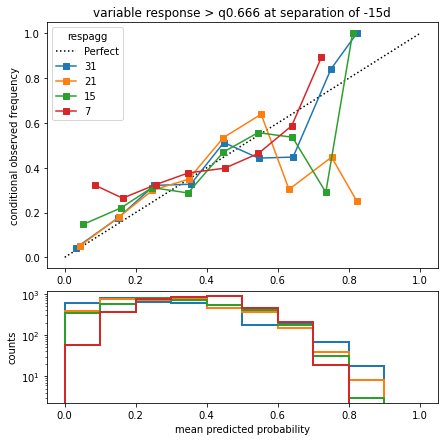

In [128]:
fig, axes = reliability_plot(y_true=ys, y_probs = preds)
axes[0].set_title(f'variable response > q{threshold} at separation of {separation}d')
plt.show()

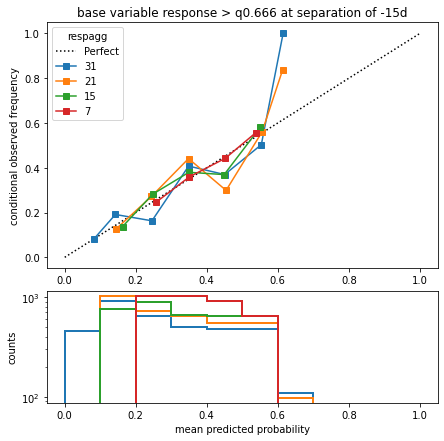

In [127]:
fig, axes = reliability_plot(y_true=ys, y_probs = predsbase)
axes[0].set_title(f'base variable response > q{threshold} at separation of {separation}d')
plt.show()

So a reliability diagram is not the most ideal way to show a greater sub-seasonal predictability of the long term variable relative to the short term variable, basically because the underlying predictability coming from the trend is larger. Still I think it is there, somewhat visible in the BSS (where the underlying baseline is varied).

## Logprob hybrid model test
Regression random forest in log-odds space.

In [2]:
respagg = 31
separation = -15
threshold = 0.666
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)
y = y > threshold

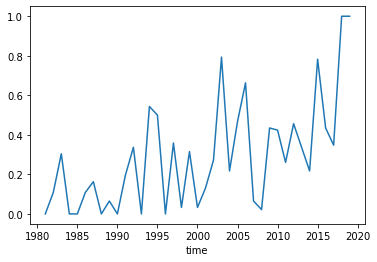

In [3]:
y.groupby(y.index.year).mean().plot()

In [6]:
logst = BaseExceedenceModel()
logst.fit(X = X, y = y)
logcl = logst.predict_log_proba(X = X)
target = y - logcl

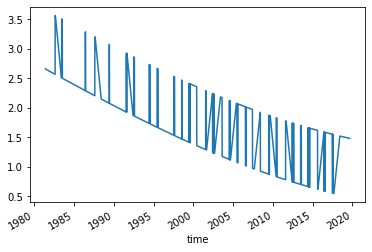

In [8]:
target.plot()

Target still has quite a trend in it. Not sure if this is going to work well.

In [19]:
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 30, n_jobs = 25, max_features = 35, n_estimators = 1500)
preds = fit_predict(rf, X_in = X, y_in = target, n_folds=5)

In [21]:
preds.index = preds.index.droplevel('fold')

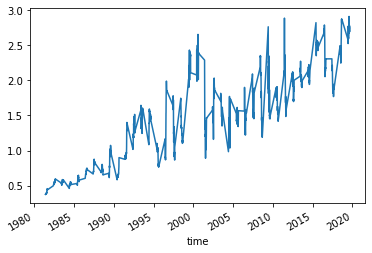

In [25]:
np.exp(preds + logcl).plot()

Not good. Actually less constrained than the other approach in which I just add probabilities.

## Quantile threshold model test

In [57]:
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy = True, with_mean = True, with_std = True)

In [114]:
respagg = 31
separation = -15
threshold = 0.8
Y_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/response.multiagg.trended.parquet'
X_path = '/scistor/ivm/jsn295/clusters_cv_spearmanpar_varalpha_strict/precursor.multiagg.parquet'
y = pd.read_parquet(Y_path).loc[:,(slice(None),respagg,slice(None))].iloc[:,0] # Only summer
X = pd.read_parquet(X_path).loc[y.index, (slice(None),slice(None),slice(None),slice(None),separation,slice(None),slice(None))].dropna(axis = 0, how = 'any')
map_foldindex_to_groupedorder(X, n_folds = 5)
y = y.reindex(X.index)

In [115]:
inp = pd.DataFrame({'date':scaler.fit_transform(X.index.to_julian_date().values[:,np.newaxis]).squeeze(), 'intercept':1}, index = y.index)
qr = QuantReg(endog =y[:,np.newaxis], exog = inp)

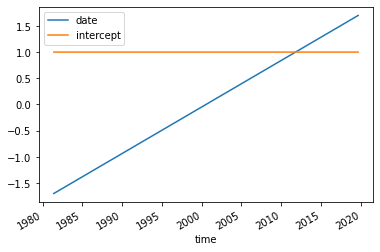

In [116]:
inp.plot()

In [117]:
ret = qr.fit(q = threshold)

/scistor/ivm/jsn295/JUPVENV/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [118]:
ret.params

date         0.481998
intercept    0.879271
dtype: float64

In [119]:
quant = inp['date'] * ret.params['date'] + inp['intercept'] * ret.params['intercept']

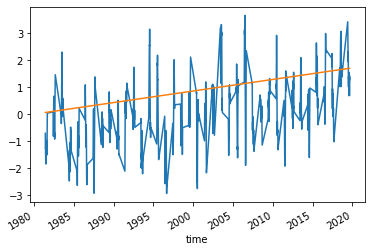

In [120]:
y.plot()
quant.plot()
plt.show()

In [121]:
target = y > quant

In [122]:
evaluate_kwds = dict(scores = [brier_score_loss], score_names = ['bs'])
m2 = RandomForestClassifier(n_estimators=1500, n_jobs=20, min_samples_split=30, max_depth=5, max_features = 35)
preds4 = fit_predict(model = m2, X_in = X, y_in = target, n_folds = 5)
preds4.index = preds4.index.droplevel('fold')
ret4 = evaluate(y_true = target, y_pred=preds4, **evaluate_kwds)

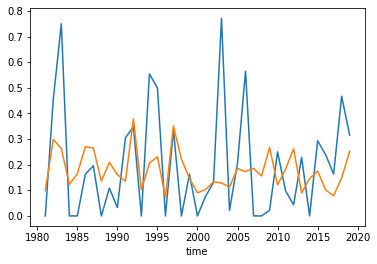

In [123]:
target.groupby(y.index.year).mean().plot()
preds4.groupby(y.index.year).mean().plot()
plt.show()

TypeError: sequence item 0: expected str instance, NoneType found

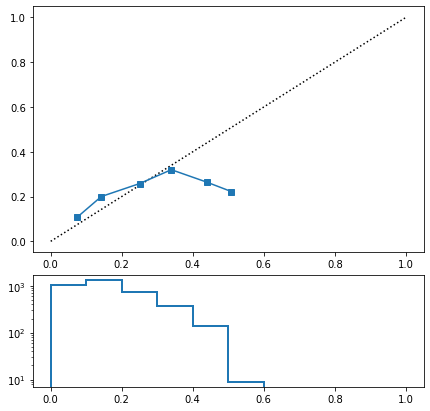

In [124]:
fig, axes = reliability_plot(y_true=target, y_probs = preds4)
axes[0].set_title(f'base variable response > q{threshold} at separation of {separation}d')
plt.show()

In [112]:
ret4

score
bs    0.217682
dtype: float64